In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import seaborn as sns; sns.set()
from datetime import datetime
import warnings
from scipy.stats import gaussian_kde

In [2]:
warnings.simplefilter('ignore')

In [3]:
# CTD and FCM data
g3_CTD = pd.read_csv('Grad3CTD.csv')
g3_fcm = pd.read_csv('g3_fcm.csv')

# meta data and rel abundance data
meta = pd.read_csv('meta_data.csv')
rel_abun = pd.read_csv('rel_abun_data.csv')

# environemntal data - nitrogen and phosphorus
g3_nutrient = pd.read_csv('Grad3Nutrients.csv')

In [4]:
# function to be used to make datetime of FCM data
def date_change_fcm(fcm_df, date_column):
    fcm_df['datetime'] = fcm_df[date_column].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S'))
    return fcm_df

In [5]:
# function used to make datetime of CTD data - can be used for both CTD and nutrient df
def date_change_CTD(CTD_df, time_column):
    CTD_df['datetime'] = CTD_df[time_column].apply(lambda x: datetime.strptime(x.split('.')[0], '%Y-%m-%dT%H:%M:%S'))
    return CTD_df

In [6]:
def date_change_meta_abun(meta_abun_df, date_column):
    meta_abun_df['datetime'] = meta_abun_df[date_column].apply(lambda x: datetime.strptime(x, '%m/%d/%y %H:%M:%S'))
    return meta_abun_df

In [7]:
# g3 FCM
g3_sub_fcm = g3_fcm[['pop', 'norm.scatter', 'norm.red', 'date', 
                    'station', 'lat', 'lon', 'depth', 'replicate']]
g3_pro_fcm = g3_sub_fcm.loc[g3_sub_fcm['pop'] == 'prochloro']

# g3 CTD
g3_ctd = g3_CTD[['time', 'lat', 'lon', 'depth', 'station', 'Temperature', 'PAR']]

# g3_nutrient subsetting and getting only dataframe with stations 
g3_nutrient_sub = g3_nutrient[['time', 'lat', 'lon', 'depth', 'Station', 'NO3_plus_NO2', 'PO4']]
g3_nutrient_sub['Station'] = pd.to_numeric(g3_nutrient_sub['Station'], errors = 'coerce')
g3_nutrient_station = g3_nutrient_sub.dropna()

In [8]:
# changing dates to datetime
g3_pro_fcm1 = date_change_fcm(g3_pro_fcm, 'date')
g3_CTD1 = date_change_CTD(g3_ctd, 'time')
g3_nutrient_time = date_change_CTD(g3_nutrient_station, 'time')

In [9]:
# rounding lat, lon, and depth of CTD df and turning them into columns
g3_CTD1['rdepth'] = g3_CTD1['depth'].apply(lambda x: round(x/5) * 5)
#g3_CTD1['rdepth'] = g3_CTD1['rdepth'].astype(float)
g3_CTD1['rlat'] = g3_CTD1['lat'].round()
g3_CTD1['rlon'] = g3_CTD1['lon'].round()

In [10]:
# rounding lat, lon, and depth of FCM df and turning them into columns
g3_pro_fcm1['rdepth'] = g3_pro_fcm1['depth'].apply(lambda x: round(x/5) * 5)
g3_pro_fcm1['rlat'] = g3_pro_fcm1['lat'].round()
g3_pro_fcm1['rlon'] = g3_pro_fcm1['lon'].round()
g3pro = g3_pro_fcm1.loc[g3_pro_fcm1['replicate'] == ' A']

In [11]:
# rounding the depth, lat, and lon and turing the new values into columns
g3_nutrient_station['rdepth'] = g3_nutrient_station['depth'].apply(lambda x: round(x/5) * 5)
g3_nutrient_station['rlat'] = g3_nutrient_station['lat'].round()
g3_nutrient_station['rlon'] = g3_nutrient_station['lon'].round()

In [12]:
# USE THIS FOR MERGED DATA OF ONLY CTD AND NUTRIENTS
g3_ctd_nutrient = g3_CTD1.merge(g3_nutrient_station, left_on = ['station', 'rdepth'], right_on = ['Station', 'rdepth'])

In [13]:
# USE THIS FOR MERGED DATA OF ONLY FCM AND CTD
g3_ctd_fcm = g3_CTD1.merge(g3pro, on = ['station', 'datetime', 'rdepth'])

In [14]:
# USE THIS FOR MERGED DATA OF ONLY CTD AND NUTRIENT (TEMP, PAR, NITROGEN, PHOSPHORUS)
g3_ctd_nutrient_sub = g3_ctd_nutrient[['station', 'Temperature', 'PAR', 'datetime_x', 'rdepth', 'rlat_x', 'rlon_x', 'NO3_plus_NO2', 'PO4']]

In [15]:
# USE THIS FOR MERGED DATAFRAME OF FCM, CTD, AND NUTRIENTS
g3_fcm_ctd_nu = g3pro.merge(g3_ctd_nutrient_sub, left_on = ['datetime', 'station', 'rdepth', 'rlat'], right_on = ['datetime_x', 'station', 'rdepth', 'rlat_x'])

In [16]:
# dataframe of g3 CTD and nutrients grouped by the depth (used to create depth profile of conditions)
g3_ctd_nutrient_gb = g3_ctd_nutrient_sub.groupby(['rdepth']).mean(['Temperature', 'PAR', 'NO3_plus_NO2', 'PO4']).reset_index()

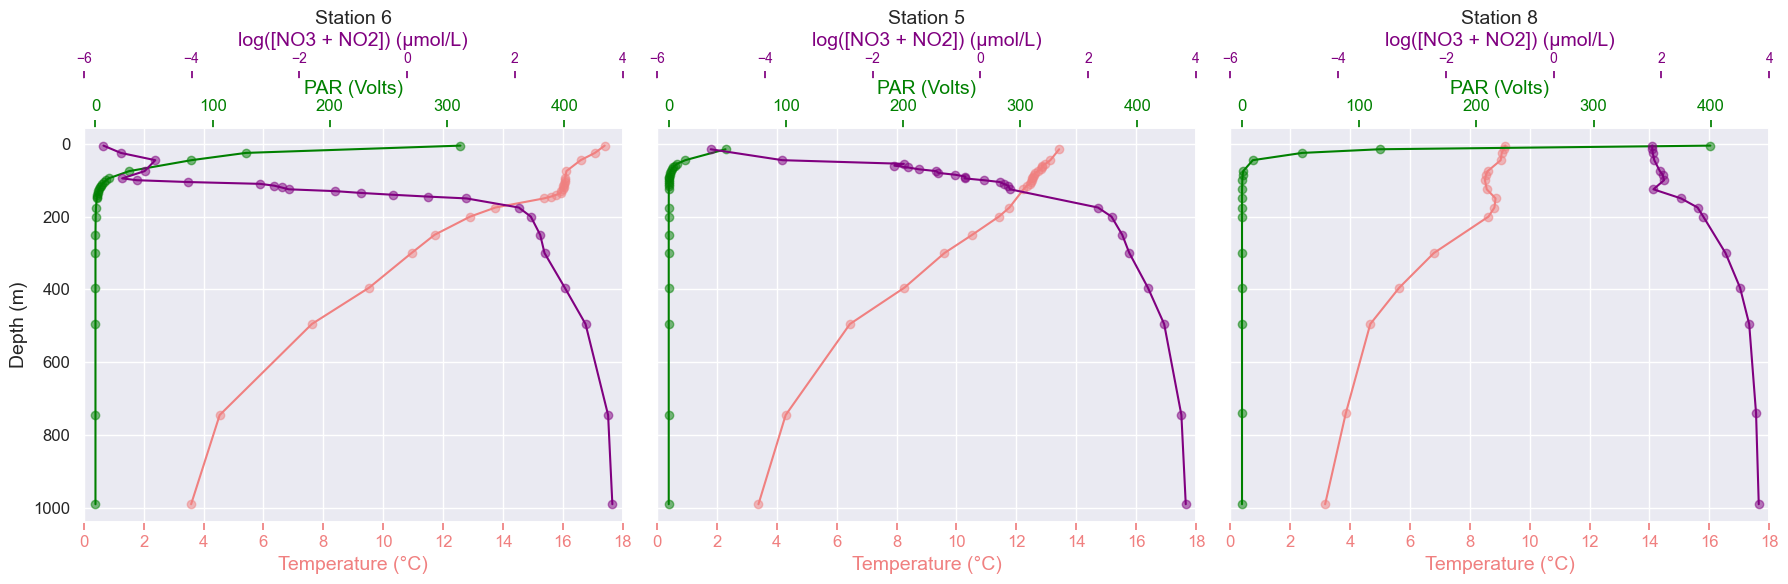

In [17]:
stations = [6, 5, 8]

fig, axes = plt.subplots(1, 3, sharey=True, figsize=(18, 6))  # 3 subplots side by side with shared y-axis

for i, station in enumerate(stations):
    ax1 = axes[i]
    g3_ctd_nutrient_station = g3_ctd_nutrient_sub.loc[g3_ctd_nutrient_sub['station'] == station]
    gb_df = g3_ctd_nutrient_station.groupby(['rdepth']).mean(['Temperature', 'PAR', 'NO3_plus_NO2', 'PO4']).reset_index()

    ctd_temp = gb_df['Temperature']
    ctd_par = gb_df['PAR']
    ctd_depth = gb_df['rdepth']
    nutrient_nitrogen = np.log(gb_df['NO3_plus_NO2'])

    # Temp axis (base)
    ax1.set_xlabel('Temperature (°C)', fontsize=14, color='lightcoral')
    ax1.plot(ctd_temp, ctd_depth, color='lightcoral')
    ax1.scatter(ctd_temp, ctd_depth, color='lightcoral', alpha=0.5)
    ax1.tick_params(axis='x', colors='lightcoral', labelsize=12)
    ax1.set_xlim(0, 18)

    if i == 0:
        ax1.set_ylabel('Depth (m)', fontsize=14)
    ax1.tick_params(axis='y', labelsize=12)
    ax1.invert_yaxis()

    # PAR axis
    ax2 = ax1.twiny()
    ax2.plot(ctd_par, ctd_depth, color='green')
    ax2.scatter(ctd_par, ctd_depth, color='green', alpha=0.5)
    ax2.set_xlabel('PAR (Volts)', fontsize=14, color='green')
    ax2.set_xlim(-10, 450)
    ax2.tick_params(axis='x', colors='green', labelsize=12)
    ax2.spines['top'].set_position(('outward', 0))
    ax2.grid(False)

    # Nitrogen axis
    ax3 = ax1.twiny()
    ax3.plot(nutrient_nitrogen, ctd_depth, color='purple')
    ax3.scatter(nutrient_nitrogen, ctd_depth, color='purple', alpha=0.5)
    ax3.set_xlabel('log([NO3 + NO2]) (μmol/L)', fontsize=14, color='purple')
    ax3.set_xlim(-6, 4)
    ax3.tick_params(axis='x', colors='purple', labelsize=10)
    ax3.spines['top'].set_position(('outward', 35))
    ax3.grid(False)

    ax1.set_title(f"Station {station}", fontsize=14)

plt.tight_layout()
plt.show()

In [18]:
# only getting the meta data we care about - Gradient 3 and replicate A
meta_df = meta[['SampleID', 'Cruise', 'Dataset', 'Station', 'Datetime', 'Latitude', 'Longitude', 'Depth', 'Replicate']]
meta_g3 = meta_df.loc[(meta_df['Cruise'] == 'km1906')]

In [19]:
# only getting the rel abundance data we care about - Gradient 3 , Pro, and replicate A
rel_abun_df = rel_abun[['SampleID', 'Genus', 'Clade', 'RelAbundance']]
pro_rel_abun = rel_abun_df.loc[rel_abun_df['Genus'] == 'Prochlorococcus']

# sample id prefix and last letter (used for replicate)
g3_prefix = 'G3.DEPTH'
g3_last_letter = 'A'
g3_pro_rel_abun = pro_rel_abun[(pro_rel_abun['SampleID'].str[:8] == g3_prefix) & 
                               (pro_rel_abun['SampleID'].str[-1] == g3_last_letter)]

In [20]:
meta_g3_rel_abun = meta_g3.merge(pro_rel_abun, on = 'SampleID')
meta_g3_rel_abun
meta_g3_surface = meta_g3_rel_abun.loc[meta_g3_rel_abun['Depth'] <= 25]
meta_g3_deep = meta_g3_rel_abun.loc[meta_g3_rel_abun['Depth'] > 70]
#meta_g3_surface

(-0.1, 1.0)

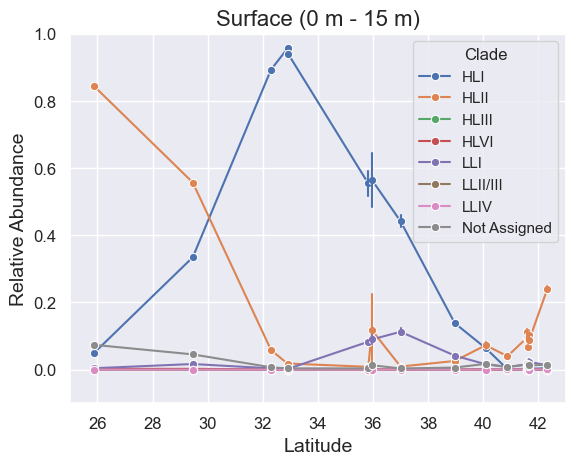

In [21]:
sns.lineplot(meta_g3_surface, x = 'Latitude', y = 'RelAbundance', hue = 'Clade', marker = 'o', errorbar = 'se', err_style = 'bars')
plt.title ('Surface (0 m - 15 m)', fontsize = 16)
plt.xlabel('Latitude', fontsize = 14)
plt.ylabel('Relative Abundance', fontsize = 14)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

plt.xlim(25, 43)
plt.ylim(-0.1, 1)

(-0.1, 1.0)

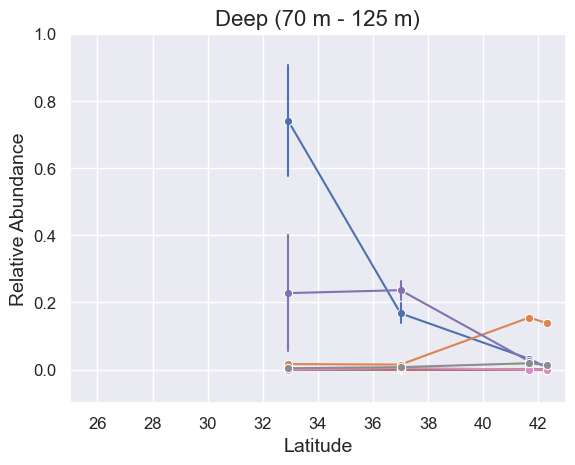

In [22]:
sns.lineplot(meta_g3_deep, x = 'Latitude', y = 'RelAbundance', hue = 'Clade', marker = 'o', errorbar = 'se', err_style = 'bars', legend = False)
plt.title('Deep (70 m - 125 m)', fontsize = 16)
plt.xlabel('Latitude', fontsize = 14)
plt.ylabel('Relative Abundance', fontsize = 14)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)


plt.xlim(25, 43)
plt.ylim(-0.1, 1)

In [23]:
# merging the meta data and relative abundance data
g3_meta_abun = meta_g3.merge(g3_pro_rel_abun, on = 'SampleID')

In [24]:
# fixing relative abundance of each clade based on sample ID
fixed_rel_abun = []

# unique sample ID for the meta abun dataframe
meta_abun_sample_id = pd.unique(g3_meta_abun['SampleID'])

for sample_id in  meta_abun_sample_id:
    id_df = g3_meta_abun.loc[g3_meta_abun['SampleID'] == sample_id]
    total_rel_abun = id_df['RelAbundance'].sum()
    for index, row in id_df.iterrows():
        original_rel_abun = row['RelAbundance']
        new_rel_abun = original_rel_abun / total_rel_abun
        fixed_rel_abun.append(new_rel_abun)

In [25]:
# adding new column for the fixed rel abun
g3_meta_abun['fixed RelAbun'] = fixed_rel_abun

In [26]:
# USE THIS DF FOR META AND REL ABUNDANCE MERGED DATA
#g3_meta_abun

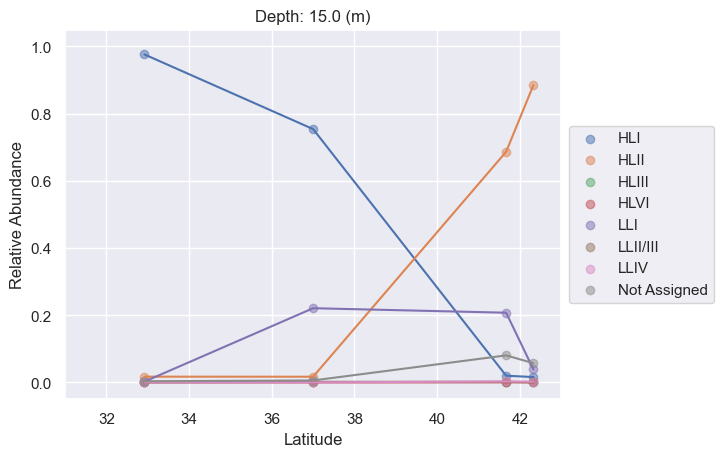

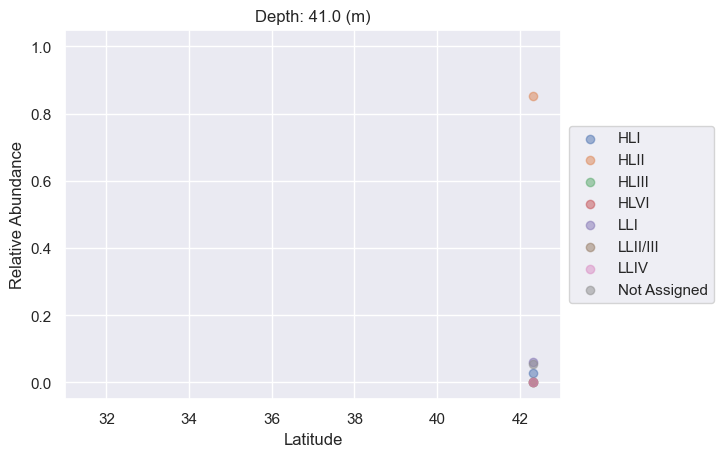

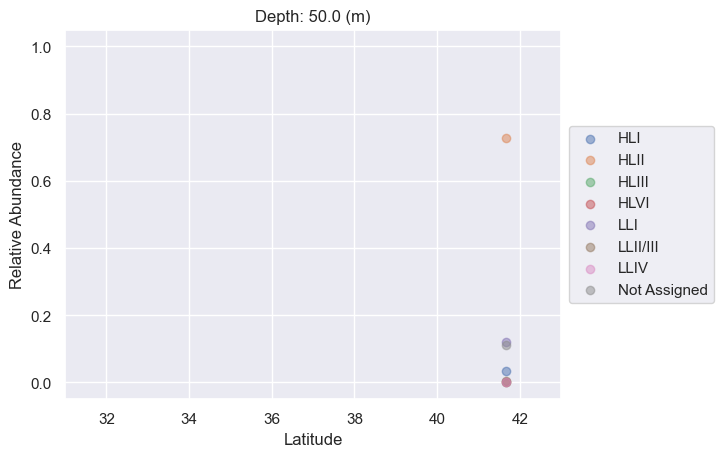

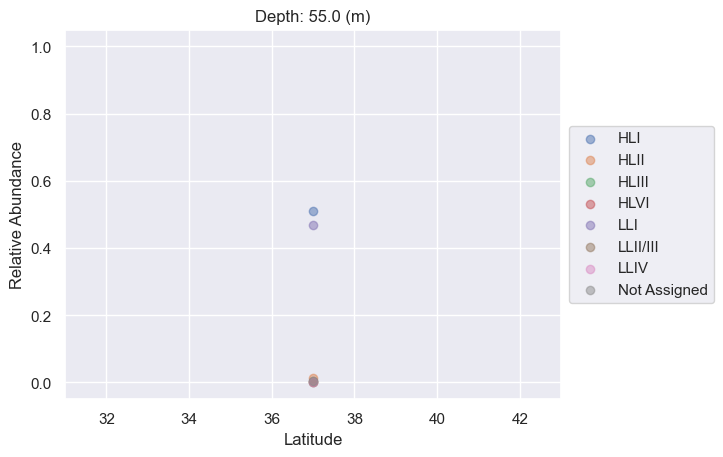

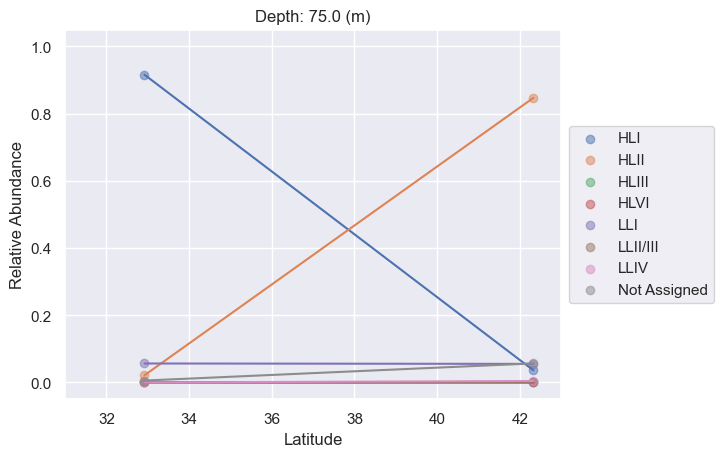

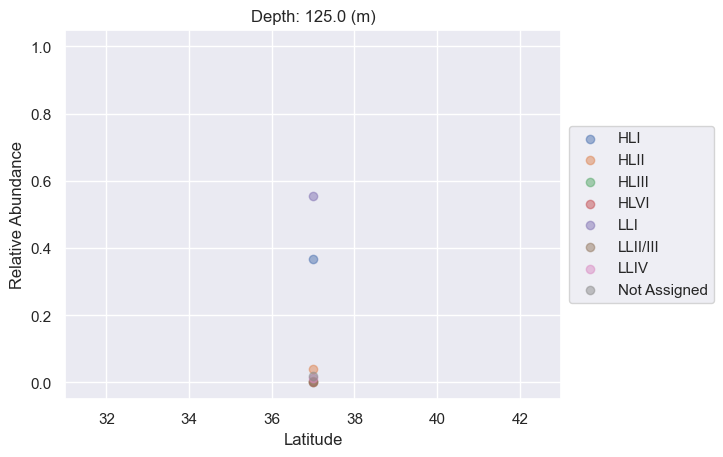

In [27]:
# for loop to make graph of each change in relative abundance of clades over latitudes at different depths
g3_meta_abun_depths = pd.unique(g3_meta_abun['Depth'])
g3_meta_abun_depths = sorted(g3_meta_abun_depths)

for depth in g3_meta_abun_depths:
    # setting up plot
    plt.figure()
    plt.title('Depth: ' + str(depth) + ' (m)')
    plt.xlabel('Latitude')
    plt.ylabel('Relative Abundance')
    plt.xlim(31, 43)
    plt.ylim(-0.05, 1.05)
    
    depth_df = g3_meta_abun.loc[g3_meta_abun['Depth'] == depth]
    unique_clades = pd.unique(depth_df['Clade'])
    for clade in unique_clades:
        clade_df = depth_df.loc[depth_df['Clade'] == clade]
        latitudes = clade_df['Latitude']
        rel_abun = clade_df['fixed RelAbun']
        line_clade = plt.plot(latitudes, rel_abun)
        point_clade = plt.scatter(latitudes, rel_abun, label = clade, alpha = 0.5)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

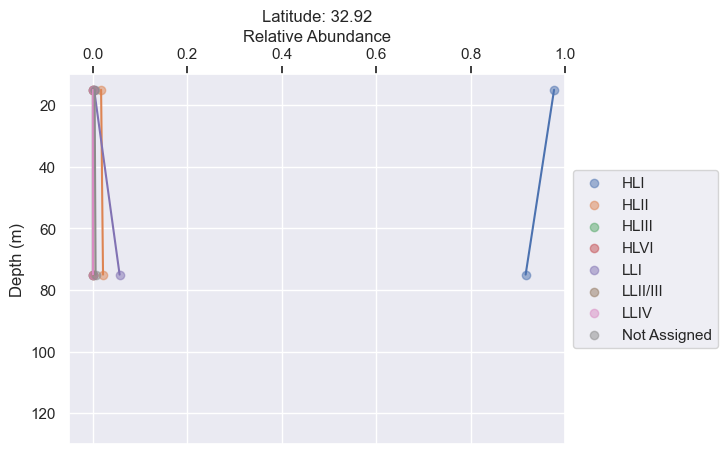

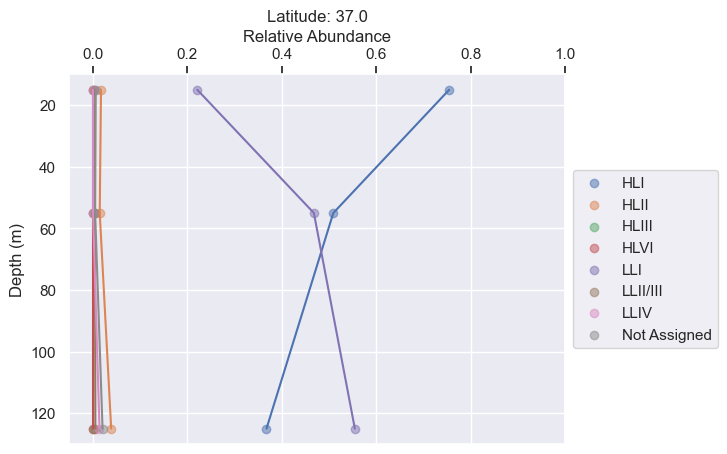

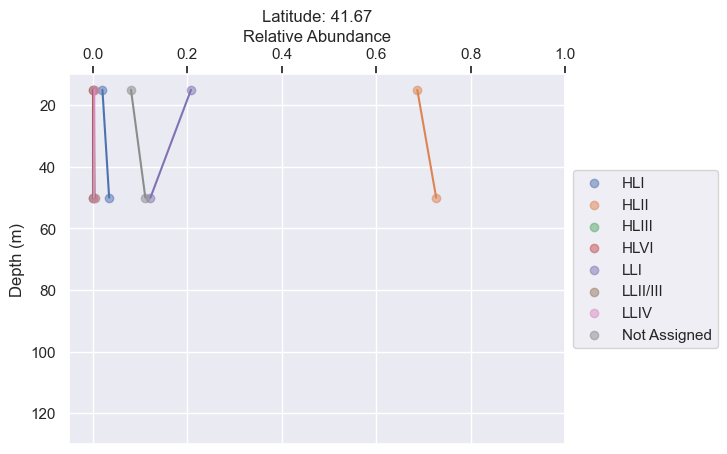

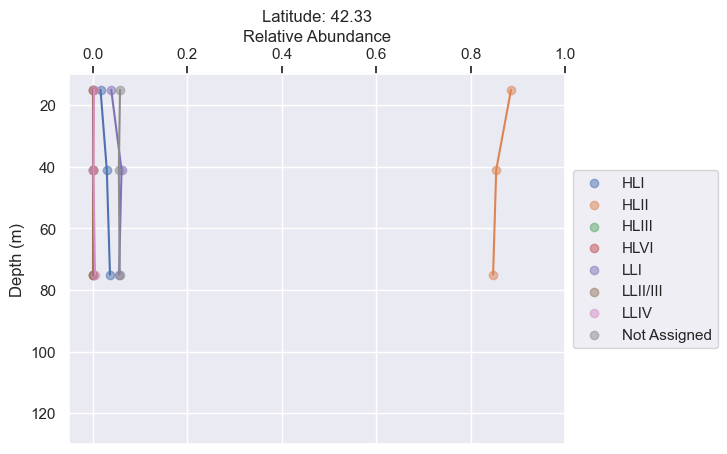

In [28]:
# creating depth profiles of Clade relative abundance at different latitudes
g3_meta_abun_lats = pd.unique(g3_meta_abun['Latitude'])
g3_meta_abun_lats = sorted(g3_meta_abun_lats)

for lat in g3_meta_abun_lats:
    # setting up plot
    plt.figure()
    plt.title('Latitude: ' + str(lat))
    plt.xlabel('Relative Abundance')
    plt.ylabel('Depth (m)')
    plt.xlim(-0.05, 1.0)
    plt.ylim(10, 130)
    plt.gca().invert_yaxis()
    plt.gca().xaxis.set_ticks_position('top')
    plt.gca().xaxis.set_label_position('top')
    
    lat_df = g3_meta_abun.loc[g3_meta_abun['Latitude'] == lat]
    unique_clades = pd.unique(lat_df['Clade'])
    for clade in unique_clades:
        clade_df = lat_df.loc[lat_df['Clade'] == clade]
        depth = clade_df['Depth']
        rel_abun = clade_df['fixed RelAbun']
        line_clade = plt.plot(rel_abun, depth)
        point_clade = plt.scatter(rel_abun, depth, label = clade, alpha = 0.5)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [29]:
# mainly HLI
HL_fcm_s6_dep15 = g3pro.loc[(g3pro['depth'] == 15) & (g3pro['station'] == 6)]
# mainly HLII
HL_fcm_s6_dep75 = g3pro.loc[(g3pro['depth'] == 75) & (g3pro['station'] == 6)]
# mainly HLI
HL_fcm_s5_dep15 = g3pro.loc[(g3pro['depth'] == 15) & (g3pro['station'] == 5)]
# mainly LLI
HL_fcm_s5_dep125 = g3pro.loc[(g3pro['depth'] == 125) & (g3pro['station'] == 5)]
# mainly HLII
HL_fcm_s8_dep15 = g3pro.loc[(g3pro['depth'] == 15) & (g3pro['station'] == 8)]
# mainly HLII
HL_fcm_s8_dep75 = g3pro.loc[(g3pro['depth'] == 75) & (g3pro['station'] == 8)]

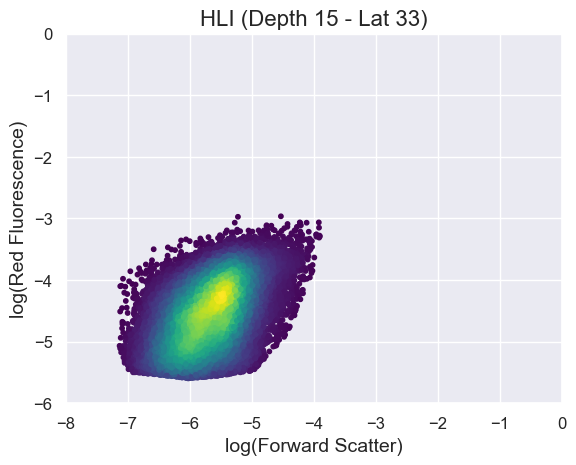

In [30]:
plt.title('HLI (Depth 15 - Lat 33)', fontsize = 16)
plt.xlabel('log(Forward Scatter)', fontsize = 14)
plt.ylabel('log(Red Fluorescence)', fontsize = 14)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

plt.ylim(-6, 0)
plt.xlim(-8, 0)

x1 = np.log(HL_fcm_s6_dep15['norm.scatter'])
y1 = np.log(HL_fcm_s6_dep15['norm.red'])

xy1 = np.vstack([x1, y1])
density1 = gaussian_kde(xy1)(xy1)

plt.scatter(x1, y1, c=density1, cmap='viridis', s=10)
# sns.scatterplot(HL_fcm_s6_dep15, x = HL_s6_d15_fsc, y = HL_s6_d15_red)
# HL_fcm_s6_dep15.map_dataframe(density_scatter1)

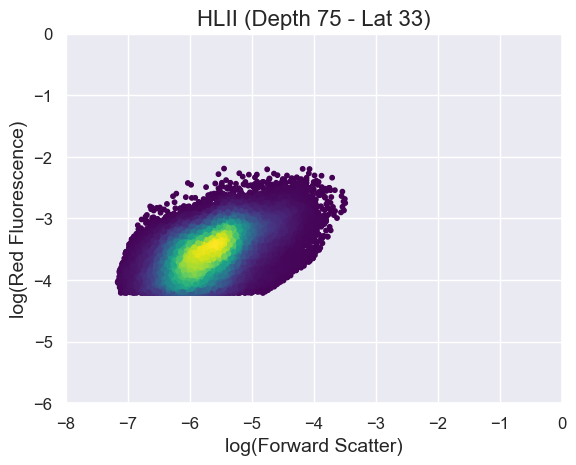

In [31]:
plt.title('HLII (Depth 75 - Lat 33)', fontsize = 16)
plt.xlabel('log(Forward Scatter)', fontsize = 14)
plt.ylabel('log(Red Fluorescence)', fontsize = 14)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

plt.ylim(-6, 0)
plt.xlim(-8, 0)

x2 = np.log(HL_fcm_s6_dep75['norm.scatter'])
y2 = np.log(HL_fcm_s6_dep75['norm.red'])

xy2 = np.vstack([x2, y2])
density2 = gaussian_kde(xy2)(xy2)

plt.scatter(x2, y2, c=density2, cmap='viridis', s=10)

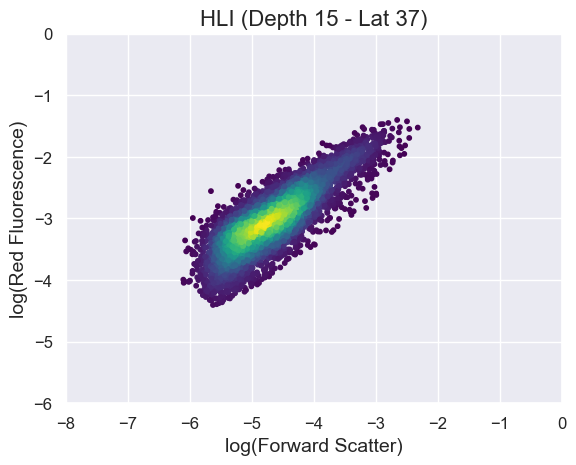

In [32]:
plt.title('HLI (Depth 15 - Lat 37)', fontsize = 16)
plt.xlabel('log(Forward Scatter)', fontsize = 14)
plt.ylabel('log(Red Fluorescence)', fontsize = 14)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

plt.ylim(-6, 0)
plt.xlim(-8, 0)

x3 = np.log(HL_fcm_s5_dep15['norm.scatter'])
y3 = np.log(HL_fcm_s5_dep15['norm.red'])

xy3 = np.vstack([x3, y3])
density3 = gaussian_kde(xy3)(xy3)

plt.scatter(x3, y3, c=density3, cmap='viridis', s=10)

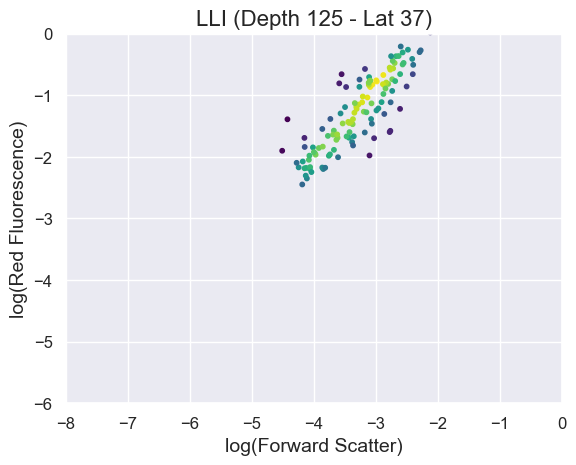

In [33]:
plt.title('LLI (Depth 125 - Lat 37)', fontsize = 16)
plt.xlabel('log(Forward Scatter)', fontsize = 14)
plt.ylabel('log(Red Fluorescence)', fontsize = 14)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

plt.ylim(-6, 0)
plt.xlim(-8, 0)

x4 = np.log(HL_fcm_s5_dep125['norm.scatter'])
y4 = np.log(HL_fcm_s5_dep125['norm.red'])

xy4 = np.vstack([x4, y4])
density4 = gaussian_kde(xy4)(xy4)

plt.scatter(x4, y4, c=density4, cmap='viridis', s=10)

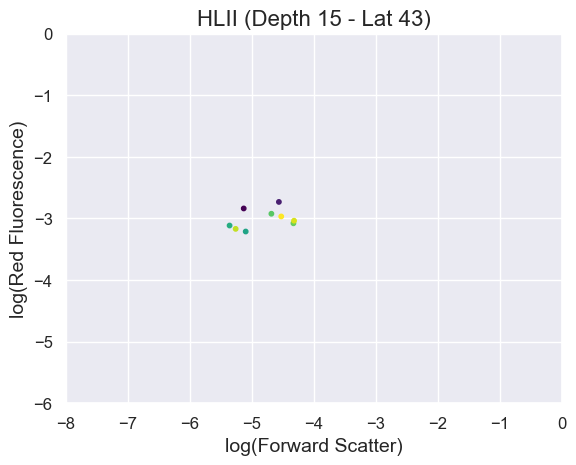

In [34]:
plt.title('HLII (Depth 15 - Lat 43)', fontsize = 16)
plt.xlabel('log(Forward Scatter)', fontsize = 14)
plt.ylabel('log(Red Fluorescence)', fontsize = 14)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

plt.ylim(-6, 0)
plt.xlim(-8, 0)

x5 = np.log(HL_fcm_s8_dep15['norm.scatter'])
y5 = np.log(HL_fcm_s8_dep15['norm.red'])

xy5 = np.vstack([x5, y5])
density5 = gaussian_kde(xy5)(xy5)

plt.scatter(x5, y5, c=density5, cmap='viridis', s=10)

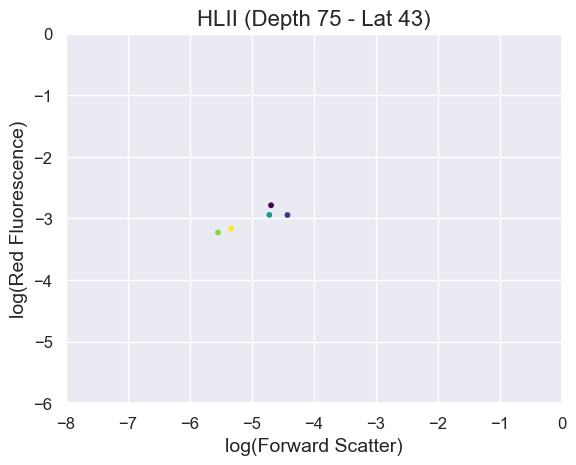

In [35]:
plt.title('HLII (Depth 75 - Lat 43)', fontsize = 16)
plt.xlabel('log(Forward Scatter)', fontsize = 14)
plt.ylabel('log(Red Fluorescence)', fontsize = 14)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

plt.ylim(-6, 0)
plt.xlim(-8, 0)

x6 = np.log(HL_fcm_s8_dep75['norm.scatter'])
y6 = np.log(HL_fcm_s8_dep75['norm.red'])

xy6 = np.vstack([x6, y6])
density6 = gaussian_kde(xy6)(xy6)

plt.scatter(x6, y6, c=density6, cmap='viridis', s=10)